In [1]:
import os
import sys
import numpy as np
import warnings
import pandas as pd
import matplotlib
from scipy import special
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

root_path = root_path = os.path.realpath('../..')
try:
    import causaltune
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))

from causaltune import CausalTune
from causaltune.scoring import Scorer
from causaltune.data_utils import CausalityDataset
from causaltune.datasets import iv_dgp_econml


warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Data Generation Process

Here we use a data generation process implemented by EconML for IV models and described as follows:

We construct the DGP as below. The instrument corresponds to a fully randomized recommendation of treatment. Then each sample complies with the recommendation to some degree. This probability depends on both the observed feature $X$ and an unobserved confounder that has a direct effect on the outcome


\begin{align}
W \sim \; & \text{Normal}(0,\, I_{n_w})   \tag{Observed confounders}\\
Z \sim \; & \text{Bernoulli}(p=0.5)   \tag{Instrument}\\
\nu \sim \; & \text{U}[0, 5] \tag{Unobserved confounder}\\
C \sim \; & \text{Bernoulli}(p=0.8 \cdot \text{Sigmoid}(0.4 \cdot X[0] + \nu))   \tag{Compliers when recommended}\\
C0 \sim \; & \text{Bernoulli}(p=0.006)   \tag{Non-Compliers when not recommended}\\
\theta = & \; 7.5\cdot X[2]\cdot X[8] \\
T = \; & C \cdot Z + C0 \cdot (1-Z)  \tag{Treatment}\\
y \sim \; & \theta \cdot T + 2 \cdot \nu + 5 \cdot (X[3]>0) + 0.1 \cdot \text{U}[0, 1]  \tag{Outcome}
\end{align}


### Model Fitting (1): Constant Effect (ATE)

We define a constant treatment effect (ATE) to be searched by CausalTune for all named IV estimators.

\begin{align}
\theta = \; & 7.5 \tag{ATE}\\
\end{align}

In [3]:
TRUE_EFFECT = 7.5

CONSTANT_EFFECT = lambda X: TRUE_EFFECT

cd = iv_dgp_econml(
    n=50000, 
    p=15, 
    true_effect=CONSTANT_EFFECT
    )

cd.preprocess_dataset()

outcome = cd.outcomes[0]

For each treatment effect example, we fit a list of 6 IV models, scoring them with an energy distance score. The dataset is split into train, validation and a hold-out test set, and we report scores for each.

As a baseline we use dowhy's simple IV estimator, implementing Wald's estimator and two-stage least squares (2SLS)
The other estimators are implemented by EconML with details [here](https://econml.azurewebsites.net/reference.html#instrumental-variable-cate-estimators)

The components time budget represent tuning budget allocated to each estimator model.

In [4]:
estimator_list = [
    "SimpleIV", 
    'SparseLinearDRIV',
    "DMLIV", 
    "OrthoIV", 
    "LinearDRIV", 
    "LinearIntentToTreatDRIV"
    ]

ct_constant_te = CausalTune(
    estimator_list=estimator_list,
    verbose=3,
    components_verbose=2,
    components_time_budget=3,
    propensity_model="dummy",
    metrics_to_report=['ate']
)

ct_constant_te.fit(data=cd, outcome=outcome)


[flaml.tune.tune: 05-17 15:48:40] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 05-17 15:48:40] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': 1}}


Initial configs: [{'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': True}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}]


[flaml.automl: 05-17 15:48:47] {2913} WARNING - Time taken to find the best model is 101% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.
[flaml.automl: 05-17 15:48:51] {2913} WARNING - Time taken to find the best model is 95% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.
[flaml.automl: 05-17 15:48:54] {2913} WARNING - Time taken to find the best model is 99% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.
[flaml.tune.tune: 05-17 15:50:05] {198} INFO - result: {'energy_distance': 0.7379278606900481, 'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'scores': {'train': {'ate': 3.6599987570242853, 'ate_std': 0.10163293280764626, 'energy_distance': 0.7260111693778892}, 'validation': {'ate': 3.660884478540306, 'ate_std': 0.10172949340779135, 'energy_distance': 0.737927860

 We get the estimated effect for the best estimator by energy distance score

In [5]:
# score all estimators on the test set
def score_all_test(models):
    for est_name, scr in models.scores.items():
        try:
            causal_estimate = scr['estimator']
            scr['scores']['test'] = models.scorer.make_scores(
                causal_estimate, 
                models.test_df, 
                problem=models.problem, 
                metrics_to_report=models.metrics_to_report
                )
        except:
            pass

def ate_mse(scores, true_effect=TRUE_EFFECT):
    return  [(v-true_effect)**2 for v in scores]


In [6]:
def get_est_effects(models, test_x, te=TRUE_EFFECT):
    est_scores = []
    for est_name, scr in models.scores.items():
        est_effect = scr["estimator"].estimator.effect(test_x).mean()
        est_scores.append([est_name, est_effect, (est_effect-te)**2])

    return pd.DataFrame(est_scores, columns=["estimator", "estimated_effect", "ate_mse"])


In [7]:
for est, scr in ct_constant_te.scores.items():
    print(scr['scores'])

{'train': {'ate': 3.6599987570242853, 'ate_std': 0.10163293280764626, 'energy_distance': 0.7260111693778892}, 'validation': {'ate': 3.660884478540306, 'ate_std': 0.10172949340779135, 'energy_distance': 0.7379278606900481}}


In [8]:
%matplotlib inline

def graph_compare_estimators(model):
    colors = ([matplotlib.colors.CSS4_COLORS['black']] +
        list(matplotlib.colors.TABLEAU_COLORS) + [
        matplotlib.colors.CSS4_COLORS['lime'],
        matplotlib.colors.CSS4_COLORS['yellow'],
        matplotlib.colors.CSS4_COLORS['pink']
    ])


    plt.figure(figsize = (7,5))
    plt.title(outcome)

    m1 = "energy_distance"
    m2 = "ate"

    splits =  [
        "train", 
        "validation", 
        ]

    for (est, scr), col in zip(model.scores.items(), colors):
        try:
            scores  = scr["scores"]
            sc = [scores[v][m1] for v in splits]
            crv = ate_mse([scores[v][m2] for v in splits])
            plt.plot(sc, crv, color=col, marker="o", label=est)
            plt.scatter(sc[1:2],crv[1:2], c=col, s=70, label="_nolegend_" )
            plt.scatter(sc[2:],crv[2:], c=col, s=120, label="_nolegend_" )

        except Exception as e:
            print(e)
            pass

    plt.xlabel(m1)
    plt.ylabel(f"{m2}_MSE")
    plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

    plt.grid()
    plt.show()


First we see the estimated effect for each model, and respective MSE compared with true effect

In [9]:
get_est_effects(ct_constant_te, ct_constant_te.test_df)

,estimator,estimated_effect,ate_mse
0,iv.econml.iv.dr.LinearDRIV,3.660884,14.738808


In the plots we show the energy distance scores on the train, validation and hold-out test sets compared with the mean squared error between estimated effect and the true effect

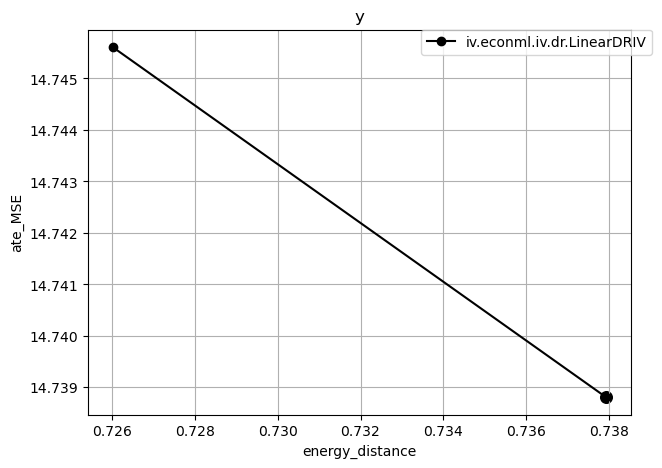

In [10]:
score_all_test(ct_constant_te)
graph_compare_estimators(ct_constant_te)

### Model Fitting (2): Heterogeneous Treatment Effect

Here we replace the constant treatment effect with a linear treatment effect function of some covariates  to estimate heterogeneous effects.

\begin{align}
\theta = \; & 7.5  \cdot   (X[2] + X[7]) \tag{ATE}\\
\end{align}

In [11]:
LINEAR_EFFECT = lambda X: TRUE_EFFECT * (X[:, 2] + X[:, 7])

cd = iv_dgp_econml(n=5000, p=15, true_effect=LINEAR_EFFECT)
cd.preprocess_dataset()

outcome = cd.outcomes[0]

In [12]:
ct_linear_te = CausalTune(
    estimator_list=estimator_list,
    verbose=3,
    components_verbose=2,
    components_time_budget=10,
    propensity_model="dummy",
)

ct_linear_te.fit(data=cd, outcome=outcome)

[flaml.tune.tune: 05-17 15:51:10] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 05-17 15:51:10] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': 1}}


Initial configs: [{'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': True}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}]


[flaml.automl: 05-17 15:51:21] {2913} WARNING - Time taken to find the best model is 71% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.
[flaml.automl: 05-17 15:51:31] {2913} WARNING - Time taken to find the best model is 87% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.
[flaml.automl: 05-17 15:51:51] {2913} WARNING - Time taken to find the best model is 85% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.
[flaml.tune.tune: 05-17 15:51:51] {198} INFO - result: {'energy_distance': 0.11106473757766544, 'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'scores': {'train': {'ate': 0.24367815154332786, 'ate_std': 6.020867399394994, 'energy_distance': 0.06943875014103895}, 'validation': {'ate': 0.10212861679820225, 'ate_std': 6.105893824443329, 'energy_distance': 0.111064737

In [25]:
get_est_effects(ct_linear_te, ct_linear_te.test_df)

,estimator,estimated_effect,ate_mse
0,iv.causaltune.models.SimpleIV,0.409788,50.271103
1,iv.econml.iv.dml.DMLIV,-0.021106,56.567042
2,iv.econml.iv.dml.OrthoIV,0.105579,54.677467
3,iv.econml.iv.dr.LinearDRIV,0.022670,55.910463
4,iv.econml.iv.dr.LinearIntentToTreatDRIV,0.284875,52.058026
5,iv.econml.iv.dr.SparseLinearDRIV,0.162762,53.835059


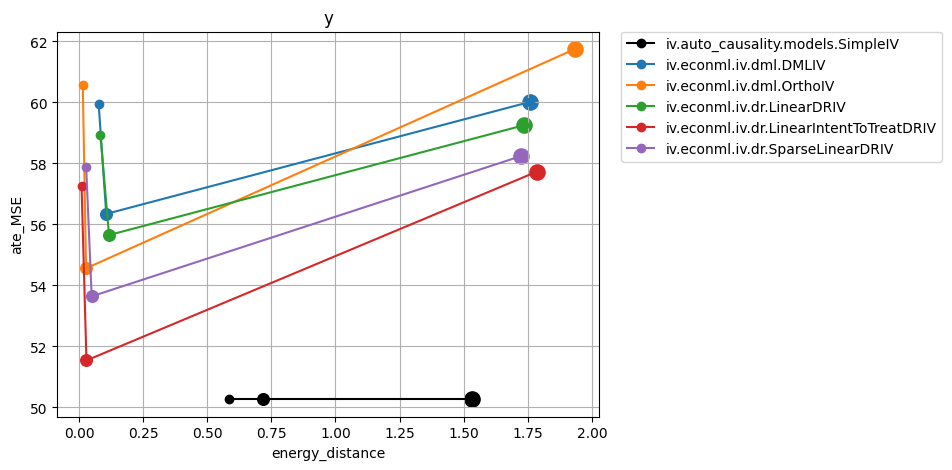

In [32]:
score_all_test(ct_linear_te)
graph_compare_estimators(ct_linear_te)

### Model Fitting (3): Non-linear Heterogeneous Treatment Effect

Finally we explore non-linear heterogeneous treatment effects with the function below:

\begin{align}
\theta = \; & 7.5  \cdot   (X[2] + X[7]) \tag{ATE}\\
\end{align}


In [17]:
QUADRATIC_EFFECT = lambda X: TRUE_EFFECT * (X[:, 2] ** 2)

cd = iv_dgp_econml(n=5000, p=15, true_effect=QUADRATIC_EFFECT)
cd.preprocess_dataset()

outcome = cd.outcomes[0]
cd.data.head()

,treatment,y,Z,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,random
4883,0.0,5.642340,0.0,-0.166649,-0.037972,-2.462183,-0.661645,-1.274812,2.164241,-1.327964,-0.051017,0.313797,-0.090737,-0.743466,0.387685,0.239865,1.189409,-2.573799,0.0
2386,0.0,2.351887,1.0,-1.471137,0.640296,0.966827,-0.630309,2.840237,-1.403959,0.993368,-0.772781,-0.332158,-0.068102,-1.589545,-0.451900,-0.904239,-0.666099,-0.479209,1.0
4030,0.0,4.001770,1.0,-0.561018,0.464426,1.549468,-0.208957,-0.813260,-0.340804,0.438366,-0.605109,-0.281733,1.120829,0.689588,1.295571,1.067522,0.424703,-0.668093,0.0
2448,0.0,8.935736,0.0,-0.841337,0.889617,-0.589731,0.392965,-0.811575,-2.079406,-0.308424,-0.056356,2.167229,-0.510654,-0.144820,0.903875,0.287287,2.137014,-0.863859,1.0
3809,0.0,5.696070,0.0,-0.849518,0.074309,0.024217,0.373959,-0.040285,0.633923,0.904897,0.516027,0.547131,0.387320,1.336018,-0.242165,-0.037972,-1.099770,-0.093276,1.0


In [35]:
ct_quad_te = CausalTune(
    estimator_list=estimator_list,
    verbose=3,
    components_verbose=2,
    components_time_budget=120,
    propensity_model="dummy",
)

ct_quad_te.fit(data=cd, outcome=outcome)


In [26]:
get_est_effects(ct_quad_te, ct_quad_te.test_df)

,estimator,estimated_effect,ate_mse
0,iv.causaltune.models.SimpleIV,7.573547,0.005409
1,iv.econml.iv.dml.DMLIV,3.591073,15.279712
2,iv.econml.iv.dml.OrthoIV,7.395235,0.010976
3,iv.econml.iv.dr.LinearDRIV,3.757597,14.005577
4,iv.econml.iv.dr.LinearIntentToTreatDRIV,7.432717,0.004527
5,iv.econml.iv.dr.SparseLinearDRIV,5.355130,4.600468


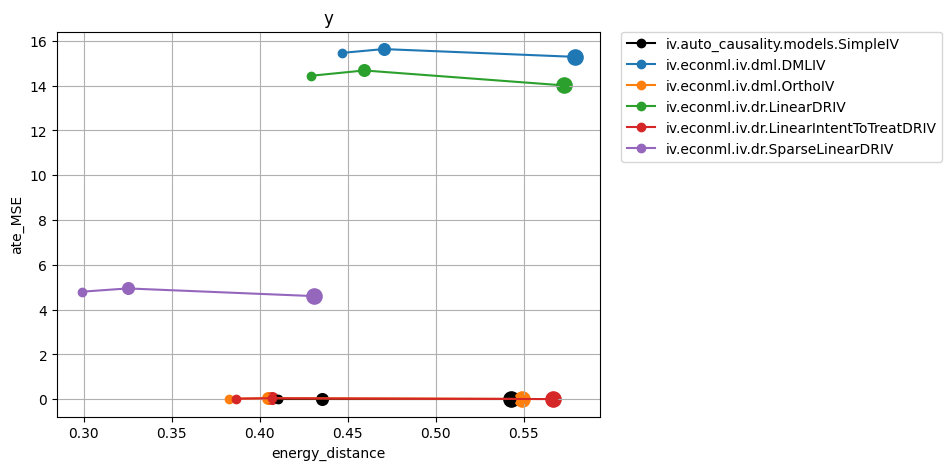

In [33]:
score_all_test(ct_quad_te)
graph_compare_estimators(ct_quad_te)
